In [1]:
%autosave 0

import numpy as np
import pandas as pd
from datetime import date, timedelta

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

from joblib import dump

Autosave disabled


In [2]:
data = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
data.head(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df_temp = data[data["date"].isin([f"{date.today()}"])] ## keep only row of today situation
i = df_temp[df_temp.location == 'World'].index ## find index of world row & drop them, i dont need it here
df_temp = df_temp.drop(i)

In [5]:
def plotSituation(subject,df=df_temp):
    """ show the days situation in the world for all features """
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.scatter(df["location"],df[f"{subject}"])
    plt.title(f"World {subject} situation")
    plt.legend
    plt.show()

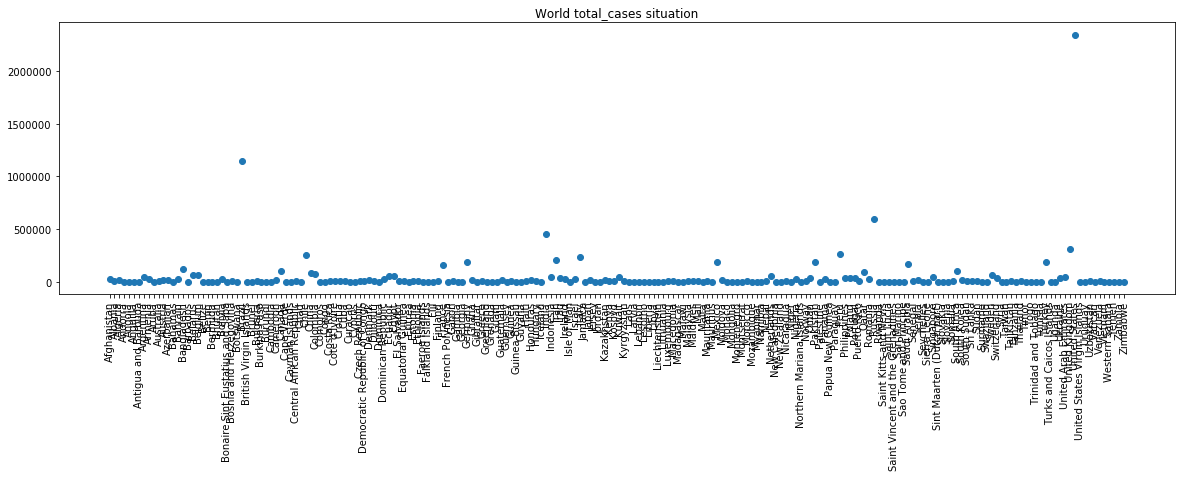

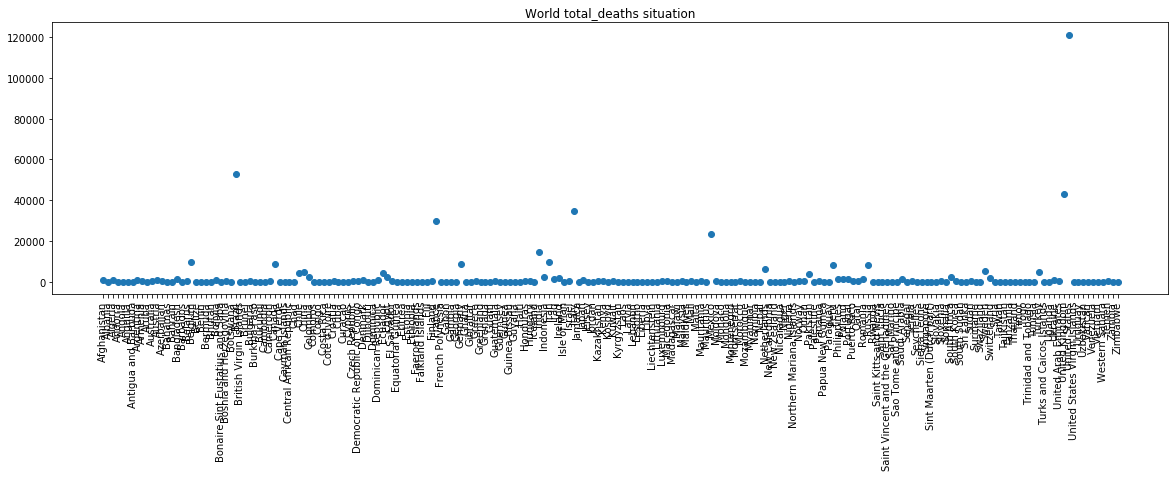

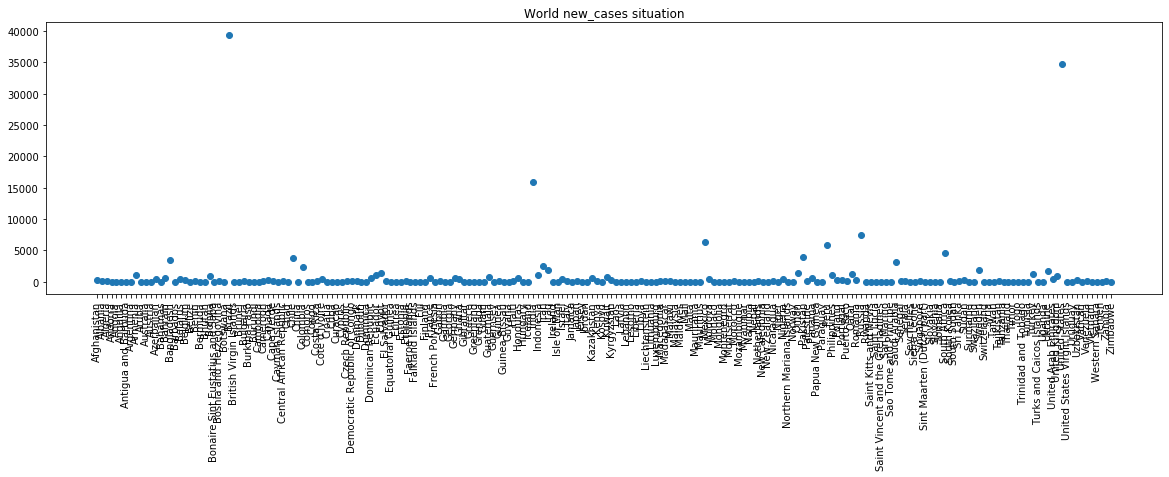

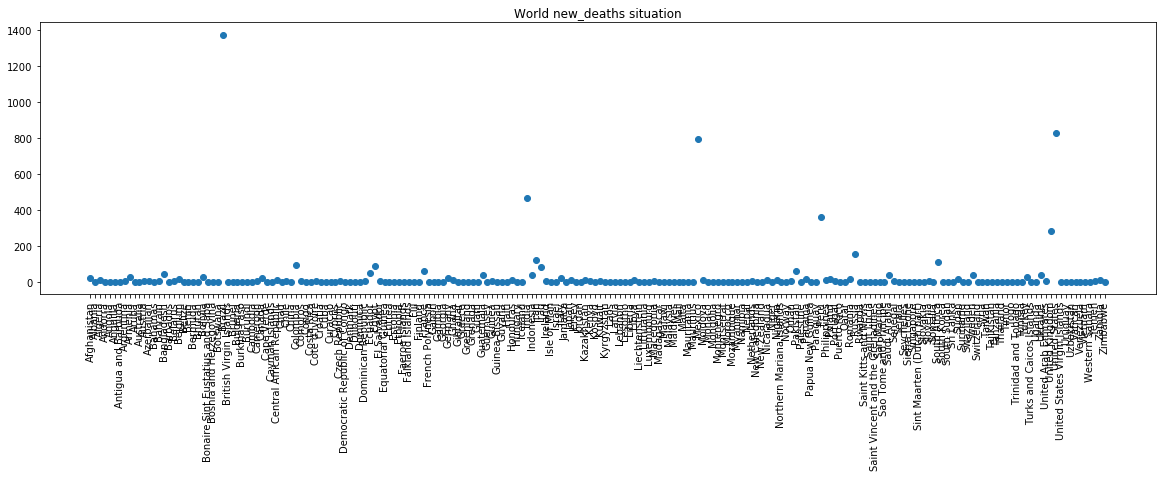

In [6]:
plotSituation("total_cases")
plotSituation("total_deaths")
plotSituation("new_cases")
plotSituation("new_deaths")

We can't read country but, this not the goal here, we will do this at the end with the clustering

In [7]:
## keep location in var before drop it
location = df_temp["location"].values

In [8]:
df = pd.DataFrame(df_temp, columns=["total_cases","new_cases","total_deaths","new_deaths"])

In [9]:
X = df.values

In [10]:
## init var of script
s_color = "#B32A4E"
seed = 69 
_k = 4

In [11]:
model = KMeans(n_clusters=_k, init='k-means++', max_iter=300, random_state=seed)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=69, tol=0.0001, verbose=0)

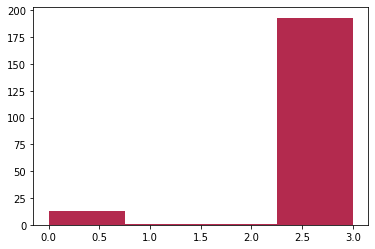

In [12]:
plt.hist(model.labels_, color=s_color, bins=_k)
plt.show()

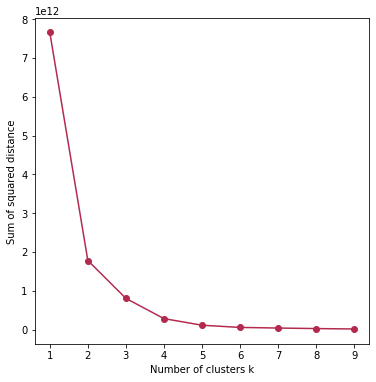

In [13]:
def bestk(): 
    """Run the Kmeans algorithm and get the index of data points clusters"""
    # never do that out of function and do not return any model from this ope
    sse = []
    list_k = list(range(1, 10))


    for k in list_k:
        ## must re create model, because K is not the _k choosen before and change at each iter
        model = KMeans(n_clusters=k, init='k-means++', max_iter=300,random_state=seed)
        model.fit(X)
        sse.append(model.inertia_)

    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o', color=s_color)
    plt.xlabel(r'Number of clusters k')
    plt.ylabel('Sum of squared distance');
    
bestk()    

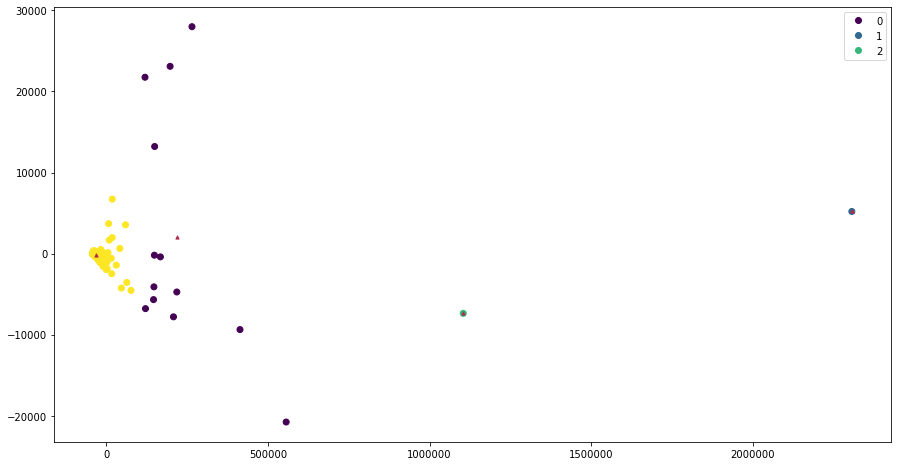

In [14]:
# reduce the features 
pca = PCA(n_components=2, random_state=seed)
reduced_features = pca.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

targets = ['0', '1', '2'] ## a way to factorize this ?? 

plt.figure(figsize=(15,8))
# plot the data
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model.predict(X))
# plot the center of cluster
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker="^", s=10, c=s_color)
# plot the legend
plt.legend(handles=scatter.legend_elements()[0], labels=targets)

-- Details Explained variance ratio --
0.999552214389253
0.00037979386507320926


Text(0, 0.5, 'variance %')

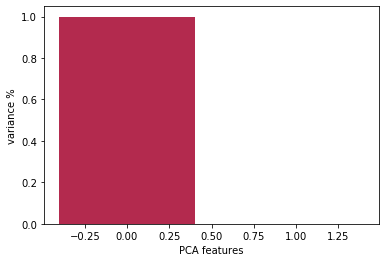

In [15]:
print("-- Details Explained variance ratio --")
for i in pca.explained_variance_ratio_:
    print(i)
    
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color=s_color)
plt.xlabel('PCA features')
plt.ylabel('variance %')

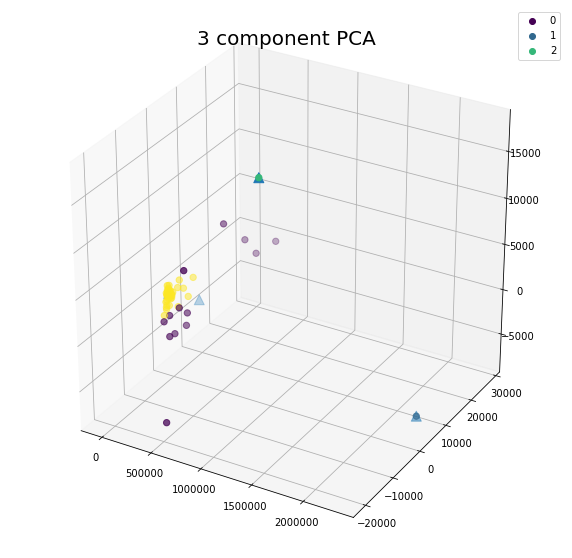

-- Details Explained variance ratio --
0.999552214389253
0.00037979386507320926
6.794657759537104e-05


Text(0, 0.5, 'variance %')

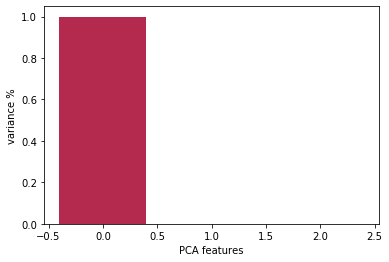

In [16]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3 component PCA', fontsize=20)

pca = PCA(n_components=3, random_state=seed)
reduced_features = pca.fit_transform(X)

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

d=model.predict(X)
f = reduced_cluster_centers[:, 0]
g = reduced_cluster_centers[:, 1]
h = reduced_cluster_centers[:,2]

x = reduced_features[:, 0]
y = reduced_features[:, 1]
z = reduced_features[:, 2]

targets = ['0', '1', '2'] ## a way to factorize this ?? 

scatter = ax.scatter(x,y,z, s=40, c=d)
ax.scatter(f,g,h, marker="^", s=100, cmap=s_color)
ax.legend(handles=scatter.legend_elements()[0], labels=targets)
ax.grid()
plt.show()

print("-- Details Explained variance ratio --")
for i in pca.explained_variance_ratio_:
    print(i)
    
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color=s_color)
plt.xlabel('PCA features')
plt.ylabel('variance %')

In [17]:
# Creating an empty dictionary 
_3dClusterList = {} 
  
# Adding list's as value 
_3dClusterList["clusterSet"] = location
_3dClusterList["clusterX"] = x
_3dClusterList["clusterY"] = y
_3dClusterList["clusterZ"] = z

## I dump the data for each location with the 3 axes x,y,z for the real 3d volume on the app
dump(_3dClusterList, "endPoint/_3dClusterList.joblib")

['endPoint/_3dClusterList.joblib']

In [18]:
# print(_3dClusterList["clusterSet"][140])
# print(_3dClusterList["clusterX"][140])
# print(_3dClusterList["clusterY"][140])
# print(_3dClusterList["clusterZ"][140])

In [19]:
# The best value is 1 and the worst value is -1. 
# Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster,
# as a different cluster is more similar.
silhouette_score(X, labels=model.predict(X))

0.889682612455557

In [20]:
df["cluster"] = model.predict(df)
df["location"] = location

#  Conclusion

In [21]:
def seeCategories(df,num_cluster):
    """ show country concerned by each cluster """
    new_df = df[df['cluster'].isin([f"{num_cluster}"])]
    return new_df

In [22]:
seeCategories(df,2)

,total_cases,new_cases,total_deaths,new_deaths,cluster,location
3516,1145906.0,39436.0,52645.0,1374.0,2,Brazil


In [23]:
seeCategories(df,0)

,total_cases,new_cases,total_deaths,new_deaths,cluster,location
4960,250767.0,3804.0,4505.0,3.0,0,Chile
8461,161267.0,517.0,29720.0,57.0,0,France
9112,191449.0,587.0,8914.0,19.0,0,Germany
10958,456183.0,15968.0,14476.0,465.0,0,India
11305,209970.0,2445.0,9863.0,121.0,0,Iran
12106,238833.0,113.0,34675.0,18.0,0,Italy
15452,191410.0,6288.0,23377.0,793.0,0,Mexico
18039,188926.0,3892.0,3755.0,60.0,0,Pakistan
18574,260810.0,5874.0,8404.0,359.0,0,Peru
19589,599705.0,7425.0,8359.0,153.0,0,Russia


In [24]:
seeCategories(df,1)

,total_cases,new_cases,total_deaths,new_deaths,cluster,location
24677,2347022.0,34720.0,121228.0,826.0,1,United States


In [25]:
seeCategories(df,3)

,total_cases,new_cases,total_deaths,new_deaths,cluster,location
166,29481.0,338.0,618.0,20.0,3,Afghanistan
274,2047.0,52.0,45.0,1.0,3,Albania
446,12076.0,156.0,861.0,9.0,3,Algeria
549,855.0,0.0,52.0,0.0,3,Andorra
644,186.0,3.0,10.0,1.0,3,Angola
734,3.0,0.0,0.0,0.0,3,Anguilla
831,26.0,0.0,3.0,0.0,3,Antigua and Barbuda
941,44918.0,0.0,1049.0,6.0,3,Argentina
1109,21717.0,1129.0,386.0,26.0,3,Armenia
1203,101.0,0.0,3.0,0.0,3,Aruba
